# srs 服务器负载测试

## 服务器配置 
- CPU 单核
- 内存 2GB

## 方案
一个进程进行推流,开启多个线程进行拉流,采集srs服务器cpu\内存\ 的使用情况


先将MediaCollector打包为jar包运行,减少ide内存与cpu占用

# 引入包

In [1]:
import cv2
import numpy as np
import subprocess as sp
import threading
import time
import json
import requests

# 定义函数

In [2]:
pipe_set = []
thread_set = []
isFinished = False
cpu_usage_set = []
memory_usage_set = []
network_out_set = []
pre_kbps = {
    "srs_sample_time" : 0,
    "srs_send_bytes" : 0
}

batch_size = 1

def get_usage_info():
    index = 1
    while  not isFinished:
        url = "http://192.168.33.100:1985/api/v1/summaries"
        myParams = {} 
        res = requests.get(url=url, params=myParams)
        res = json.loads(res.text)
        cpu = res['data']["self"]['cpu_percent']
        mem = res['data']["self"]['mem_kbyte']
        net_out = 0
        diff = res['data']["system"]['srs_sample_time'] - pre_kbps['srs_sample_time']
        if (diff > 0) :
            # kbps.out.srs = (data.data.system.srs_send_bytes - $scope.pre_kbps.system.srs_send_bytes) * 8 / diff;
            net_out = (res['data']["system"]['srs_send_bytes'] - pre_kbps['srs_send_bytes']) * 8 / diff
        
        pre_kbps['srs_sample_time'] = res['data']["system"]['srs_sample_time']
        pre_kbps['srs_recv_bytes'] = res['data']["system"]['srs_recv_bytes']
        print(cpu,'\t',mem,'\t',net_out)
        cpu_usage_set.append(cpu)
        memory_usage_set.append(mem)
        network_out_set.append(net_out)
        time.sleep(1)
        index = index + 1

def start_streaming(pipe_set, batch_size):
    for i in range(batch_size):
        rtmpUrl = 'rtmp://192.168.33.100/live/livestream'
        command = ['ffplay','-fflags','nobuffer','-x', '1280',  '-y', '720',  '-i', rtmpUrl]
        pipe = sp.Popen(command,stdin=sp.PIPE, shell=False)
        pipe_set.append(pipe)
    start(pipe_set)

def stop(pipe_set): 
    for pipe in pipe_set:
        print('close pipe'+ str(pipe))
        pipe.terminate()
        if not pipe.poll() :
            print('kill'+str(pipe))
            pipe.kill()
    

def start(pipe_set):
    for pipe in pipe_set:
        _thread = threading.Thread(target = pipe.wait)
        thread_set.append(_thread)
        _thread.start()
        print(_thread)
        
def exit():
    cmd = input("enter 'exit' to exit")
    while(cmd != 'exit'):
        cmd = input("enter 'exit' to exit")
    stop(pipe_set)

# 开始测试

通过定义`batch_size`控制播放端数量，并记录服务器的**cpu、内存、出口带宽**

In [142]:
pipe_set = []
thread_set = []
isFinished = False
cpu_usage_set = []
memory_usage_set = []
network_out_set = []
pre_kbps = {
    "srs_sample_time" : 0,
    "srs_send_bytes" : 0
}

batch_size = 20
streaming_thread = threading.Thread(target=start_streaming,args = (pipe_set, batch_size))
statistic_thread = threading.Thread(target=get_usage_info)
streaming_thread.start()
statistic_thread.start()

thread_exit = threading.Thread(target= exit)
thread_exit.start()
thread_exit.join()
streaming_thread.join()

isFinished = True
statistic_thread.join()

第 1 次统计
0.12 	 31312 	 0.014217862850273256
<Thread(Thread-558 (wait), started 17784)>
<Thread(Thread-559 (wait), started 7524)>
<Thread(Thread-560 (wait), started 1148)>
<Thread(Thread-561 (wait), started 17096)>
<Thread(Thread-562 (wait), started 17392)>
<Thread(Thread-563 (wait), started 2596)>
<Thread(Thread-564 (wait), started 8172)>
<Thread(Thread-565 (wait), started 16532)>
<Thread(Thread-566 (wait), started 17752)>
<Thread(Thread-567 (wait), started 2356)>
<Thread(Thread-568 (wait), started 17372)>
第 2 次统计
<Thread(Thread-569 (wait), started 1184)>
<Thread(Thread-570 (wait), started 7760)>
<Thread(Thread-571 (wait), started 5852)>
<Thread(Thread-572 (wait), started 16096)>
0.1 	 31312 	 7964162.32069195
<Thread(Thread-573 (wait), started 2776)>
<Thread(Thread-574 (wait), started 17528)>
<Thread(Thread-575 (wait), started 15836)>
<Thread(Thread-576 (wait), started 1284)>
<Thread(Thread-577 (wait), started 696)>
第 3 次统计
0.36 	 31312 	 0
第 4 次统计
0.55 	 31312 	 7832756.507521256
第 5

# 采集数据可视化并保存
对采集的数据进行可视化

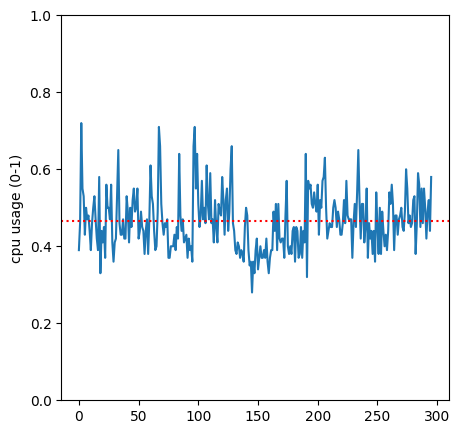

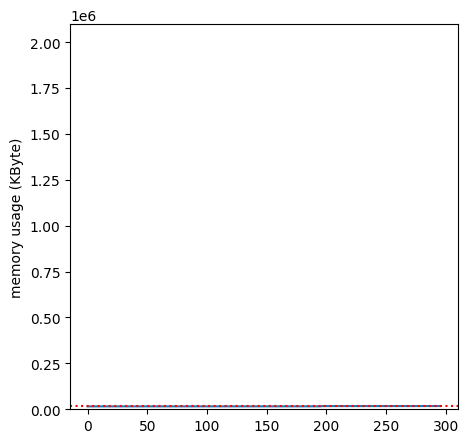

[0, 57250.92562520299, 0, 0, 91647.09335080249, 0, 0, 121134.33981841763, 0, 154377.60689426583, 0, 0, 178509.34571997347, 0, 209390.37288135593, 0, 0, 234703.38923327895, 0, 0, 260999.08655126498, 0, 285350.4638935108, 0, 0, 314659.2624958623, 0, 347521.29607451765, 0, 0, 364089.8425351193, 0, 0, 405358.70443185605, 0, 420972.34805194807, 0, 0, 449791.3970110461, 0, 489158.9953488372, 0, 0, 510496.8888888889, 0, 0, 544648.7352355673, 0, 550750.4364820847, 0, 0, 582393.6233809366, 0, 598411.1169861202, 0, 0, 595665.6958053154, 0, 0, 626599.4558001972, 0, 638542.0826446281, 0, 0, 689445.0739506995, 0, 689086.8367413178, 0, 0, 738655.4264852307, 0, 762834.816, 0, 0, 782137.3572854291, 0, 804913.9986675549, 0, 0, 789870.3201024327, 0, 0, 841254.3723404255, 0, 865946.4558139535, 0, 0, 889346.3986733002, 0, 910018.1574227831, 0, 0, 923489.2895522388, 0, 941060.791500664, 0, 0, 929614.31552, 0, 0, 934340.983729662, 0, 1013058.8166776969, 0, 0, 1022970.8506933247, 0, 1090741.7641572284, 0, 0,

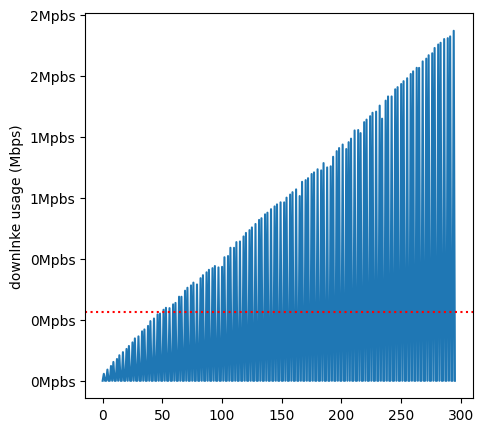

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

cpu_usage_set = cpu_usage_set[1:-1]
memory_usage_set = memory_usage_set[1:-1]
network_out_set = network_out_set[1:-1]

cpu_mean = np.mean(cpu_usage_set)
mem_mean = np.mean(memory_usage_set)
net_mean = np.mean(network_out_set)

# 绘制cpu使用图
plt.figure(num=1, figsize=(5,5) )
plt.plot(cpu_usage_set)
plt.ylim((0,1))
plt.ylabel('cpu usage (0-1)')
plt.axhline(cpu_mean, color='red', linestyle=':')
plt.savefig('F:/学习/knowledgeBase/cpu_'+str(batch_size))
plt.show()

# 绘制内存占用图
plt.figure(num=2, figsize=(5,5))
plt.plot(memory_usage_set)
plt.ylim((0,2048*1024))
plt.ylabel('memory usage (KByte)')
plt.axhline(mem_mean, color='red', linestyle=':')
plt.savefig('F:/学习/knowledgeBase/mem_'+str(batch_size))
plt.show()

# 处理Y轴单位
def y_update_scale_value(temp, position):
    result = float(temp/1024/1024)
    return "{}Mpbs".format(int(result))

# 绘制网络占用
print(network_out_set)
plt.figure(num=3, figsize=(5,5))
plt.plot(network_out_set)
plt.ylabel('downlnke usage (Mbps)')
plt.axhline(net_mean, color='red', linestyle=':')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_update_scale_value))
plt.savefig('F:/学习/knowledgeBase/upl_'+str(batch_size))
plt.show()

# 写入文件
将计算的均值写入文件，方便后续对均值的可视化

In [73]:
# 写入文件
import time 

# cpu_filename = 'e:/cpu_out.txt'
# mem_filename = 'e:/mem_out.txt'
# upl_filename = 'e:/upl_out.txt'

# 注释，防止误操作写入
# with open(cpu_filename, 'a') as f:
#     f.write(str(cpu_mean)+',')
#     f.close()

# with open(mem_filename, 'a') as f:
#     f.write(str(mem_mean)+',')
#     f.close()

# with open(upl_filename, 'a') as f:
#     f.write(str(net_mean)+',')
#     f.close()



print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())+'\n writing file finished , \ncpu:'+str(cpu_mean),'\t men:',mem_mean,'\t net:', net_mean)


2023-05-12 11:31:43
 writing file finished , 
cpu:0.6664563106796118 	 men: 39841.669902912625 	 net: 39764780.87125539


# CPU均值

0.34


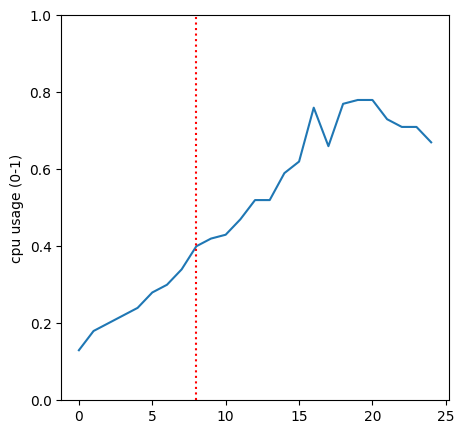

In [127]:
import numpy as np 

cpu_filename = 'e:/cpu_out.txt'
cpu_mean_list = []

with open(cpu_filename, 'r') as f:
    for line in f:
        cpu_mean_list = line.split(',')
    f.close()
    
del cpu_mean_list[len(cpu_mean_list)-1]
cpu_mean_list = [float(x) for x in cpu_mean_list]
cpu_mean_list = list(np.round(np.array(cpu_mean_list),2))

print(cpu_mean_list[7])

plt.figure(num=11, figsize=(5,5))
plt.plot(cpu_mean_list)
plt.ylim((0,1))
plt.axvline(8, color='red', linestyle=':')
plt.ylabel('cpu usage (0-1)')
plt.show()

# 内存均值

18461.77


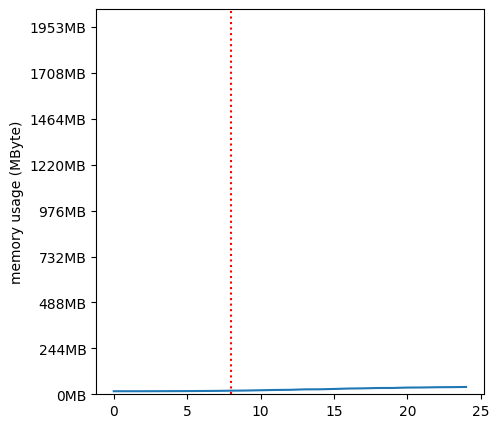

In [128]:
import numpy as np 
from matplotlib.ticker import FuncFormatter

# 处理Y轴单位 KB
def y_update_scale_value(temp, position):
    result = temp/1024
    return "{}MB".format(int(result))

mem_filename = 'e:/mem_out.txt'
mme_mean_list = []

with open(mem_filename, 'r') as f:
    for line in f:
        mme_mean_list = line.split(',')
    f.close()
    
del mme_mean_list[len(mme_mean_list)-1]
mme_mean_list = [float(x) for x in mme_mean_list]
mme_mean_list = list(np.round(np.array(mme_mean_list),2))
print(mme_mean_list[7])

plt.figure(num=22, figsize=(5,5))
plt.plot(mme_mean_list)
plt.ylim((0,2048*1024))
plt.axvline(8, color='red', linestyle=':')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_update_scale_value))
plt.ylabel('memory usage (MByte)')
plt.show()


# 出口带宽均值

[430671.41, 803359.35, 1063199.49, 1447024.63, 1941620.61, 2493881.52, 3169429.9, 3932110.06, 4818229.09, 5870683.37, 7023017.07, 8238106.71, 9800873.67, 11193530.6, 12977459.3, 14729896.04, 19268990.24, 18781125.69, 22155003.66, 26823251.95, 29721177.72, 31468640.95, 34555534.54, 36180780.96, 39764780.87] 

3932110.06


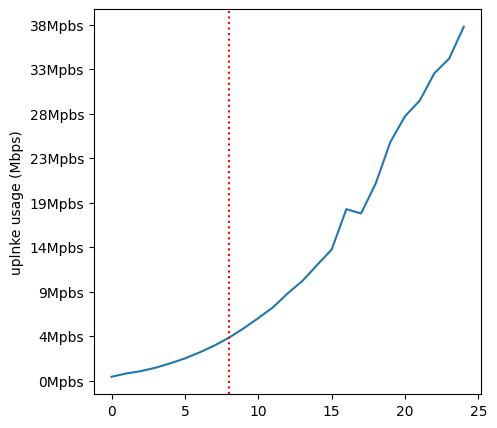

In [129]:
import numpy as np
from decimal import Decimal
from matplotlib.ticker import FuncFormatter

# 处理Y轴单位
def y_update_scale_value(temp, position):
    result = temp/1024/1024
    return "{}Mpbs".format(int(result))

upl_filename = 'e:/upl_out.txt'
upl_mean_list = []

with open(upl_filename, 'r') as f:
    for line in f:
        upl_mean_list = line.split(',')
    f.close()
del upl_mean_list[len(upl_mean_list)-1]
upl_mean_list = [float(x) for x in upl_mean_list]
upl_mean_list = list(np.round(np.array(upl_mean_list),2))
print(upl_mean_list, '\n')
print("",upl_mean_list[7])

# 绘制网络占用
plt.figure(num=33, figsize=(5,5))
plt.plot(upl_mean_list)
plt.axvline(8, color='red', linestyle=':')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_update_scale_value))
plt.ylabel('uplnke usage (Mbps)')
plt.show()

# 问题分析
当25个播放端进行播放时，画面严重卡顿，进行进一步实验找到播放流畅的临界值为：8  

在此时测量的资源占用图为：  
- cpu 
- 出口带宽 3932110bps = 3.9Mbps  
![cpu占用图](srs拉流测试/cpu_8.png)  
![内存占用图](srs拉流测试/mem_8.png)
![出口带宽](srs拉流测试/upl_8.png)